<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/4a_validacion_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selección de modelos de regresión
En esta libreta evaluaremos un modelo de regresión usando valación cruzada.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

Definimos la función de pérdida de error cuadrático medio

$$
$$

In [0]:
def ecm(y, y_hat):
  return np.square(y_hat - y).mean()

Definimos la función para realizar validación cruzada aleatoria

In [0]:
def vc_aleatorio(X, y, n = 100, t_ent=0.8):
  for i in range(n):
    perm = np.random.permutation(X.shape[0])
    
    X = X[perm,:]
    y = y[perm]
    
    X_ent = X[:int(X.shape[0] * t_ent),:]
    y_ent = y[:int(X.shape[0] * t_ent)]

    X_val = X[int(X.shape[0] * t_ent):,:]
    y_val = y[int(X.shape[0] * t_ent):]
    
    yield i, X_ent, y_ent, X_val, y_val

De forma similar, definimos la función para realizar validación cruzada de $K$ particiones

In [0]:
def vc_kpart(X, y, k = 10):
  t_pliegue = int(X.shape[0] / 10)
  for i in range(k):
    masc_val = np.zeros(X.shape[0], dtype=bool)
    masc_val[t_pliegue * i:t_pliegue * (i + 1)] = True
    ent_mask = np.logical_not(masc_val)
    X_ent = X[ent_mask, :]
    y_ent = y[ent_mask]
    X_val = X[masc_val, :]
    y_val = y[masc_val]
    
    yield i, X_ent, y_ent, X_val, y_val

Validación de K particiones con repetición

In [0]:
def vcrep_kpart(X, y, n=10, k=4, t_ent=0.8):
  for i in range(n):
    perm = np.random.permutation(X.shape[0])
    X = X[perm,:]
    y = y[perm]
    for j in range(k):
      masc_val = np.zeros(X.shape[0], dtype=bool)
      masc_val[t_pliegue*j:t_pliegue*(j+1)] = True
      ent_mask = np.logical_not(masc_val)
      X_ent = X[ent_mask, :]
      y_ent = y[ent_mask]
      X_val = X[masc_val, :]
      y_val = y[masc_val]
      
      yield i, j, i * k + j, X_ent, y_ent, X_val, y_val

Definimos nuestra función para entrenar y validar el modelo de regresión con expansión polinomial de un grado dado

In [0]:
def entrena_evalua(m, X_ent, y_ent, X_val, y_val):
  m.fit(X_ent, y_ent)

  y_hat_ent = m.predict(X_ent)
  y_hat_val = m.predict(X_val)

  ecm_ent = ecm(y_ent, y_hat_ent)
  ecm_val = ecm(y_val, y_hat_val) 

  return ecm_ent, ecm_val

Nuestra función de expansión polinomial

In [0]:
def expol(X, grado):
  phi_X = X
  for i in range(grado - 1):
    powerX = np.power(X, i + 2)
    phi_X = np.column_stack((phi_X, powerX))
    
  unos = np.ones(phi_X.shape[0])
  return np.column_stack((unos, phi_X))

Creamos nuestra clase base para regresión lineal

In [0]:
class RegresionLineal():
  def fit(self, X, y):
    '''
    Estima los parámetros del modelo
    '''
    self._estima_parametros(X, y)
  
  def predict(self, X):
    '''
    Predice valores de vectores dados
    '''
    return X @ self.parametros

Generamos un hijo de esta clase para mínimos cuadrados usando descomposición QR

In [0]:
class MinimosCuadradosQR(RegresionLineal):
  def _estima_parametros(self, X, y):
    q, r = np.linalg.qr(X)
    self.parametros = np.linalg.inv(r) @ q.T @ y

La evaluación la vamos a realizar con el conjunto de datos de precios de casas de la ciudad de Boston, la cual se puede descargar desde scikit-learn

In [0]:
boston = load_boston()

Entrenamos y validamos nuestro modelo

In [0]:
from sklearn.linear_model import LinearRegression

grados = np.arange(1,20,1)
ecm_ent_grados = np.zeros((grados.shape[0], 100))
ecm_val_grados = np.zeros((grados.shape[0], 100))
for i,g in enumerate(grados):
  X = expol(boston.data, g)
  y = boston.target
  for j, X_ent, y_ent, X_val, y_val in vc_aleatorio(X, y, n=100, t_ent=0.8):
    ecm_ent_grados[i,j], ecm_val_grados[i,j] = entrena_evalua(MinimosCuadradosQR(), 
                                                              X_ent, y_ent,
                                                              X_val, y_val)

Graficamos los errores cuadráticos medios de entrenamiento y validación

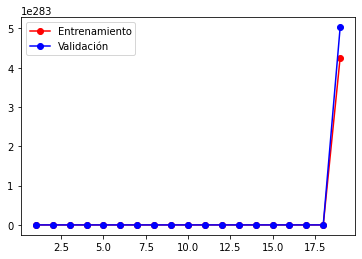

In [42]:
plt.plot(grados, ecm_ent_grados.mean(axis=1), 'o-', color="r",
         label="Entrenamiento")
plt.plot(grados, ecm_val_grados.mean(axis=1), 'o-', color="b",
         label=u"Validación")
plt.legend()
plt.show()

Para mínimos cuadrados penalizados por norma $\ell_2$ tenemos

In [0]:
class MinimosCuadradosL2QR(RegresionLineal):
  def __init__(self, lc = 0.01):
    self._lc = lc

  def _estima_parametros(self, X, y):
    lcI = np.sqrt(self._lc * np.identity(X.shape[1]))
    X_tilde = np.concatenate((X, lcI))
    y_tilde = np.concatenate((y, np.zeros(X.shape[1])))
    q, r = np.linalg.qr(X_tilde)
    self.parametros = np.linalg.inv(r) @ q.T @ y_tilde

Evaluamos el rendimiento para distintos valores de $\lambda$.

In [0]:
lambdas = np.geomspace(1e-20, 1e20, num=9)
ecm_ent_lambdas = np.zeros((lambdas.shape[0],100))
ecm_val_lambdas = np.zeros((lambdas.shape[0],100))
for i,l in enumerate(lambdas):
  X = expol(boston.data, 14)
  y = boston.target
  for j, X_ent, y_ent, X_val, y_val in vc_aleatorio(X, y, n=100, t_ent=0.8):
    ecm_ent_lambdas[i,j], ecm_val_lambdas[i,j] = entrena_evalua(MinimosCuadradosL2QR(lc=l), 
                                                               X_ent, y_ent,
                                                               X_val, y_val)

Graficamos los errores para entrenamiento y validación

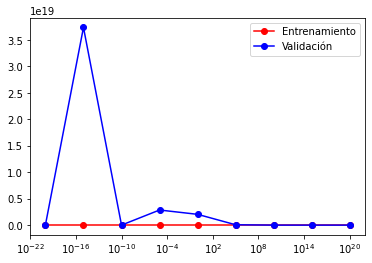

In [45]:
plt.plot(lambdas, ecm_ent_lambdas.mean(axis=1), 'o-', color="r",
         label="Entrenamiento")
plt.plot(lambdas, ecm_val_lambdas.mean(axis=1), 'o-', color="b",
         label=u"Validación")
plt.xscale('log')
plt.legend()
plt.show()